In [1]:
import numpy as np
import pandas as pd
import os
import scipy.io
import scipy.signal as sp
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F



### Dataset
#### https://data.mendeley.com/datasets/37pm7jk7jn/1 

In [2]:
# Set your dataset path
DATASET_PATH = "dataset"
rawdata_folder = os.path.join(DATASET_PATH, "RawData")
labels_folder = os.path.join(DATASET_PATH, "Labels")

### Data loading 

In [3]:
def load_csv_file_new(file_path):
    """Load .csv file and return the last column's values."""
    # Read the CSV file into a DataFrame
    data = pd.read_csv(file_path)
    
    # Assuming you want the last column
    return data.iloc[:, -1].values  # returns the last column values

def load_csv_file(file_path):
    """Load .csv file and return glucose value."""
    label_data = pd.read_csv(file_path)
    glucose = label_data.iloc[0, 3]  # 4th column, first row
    return glucose

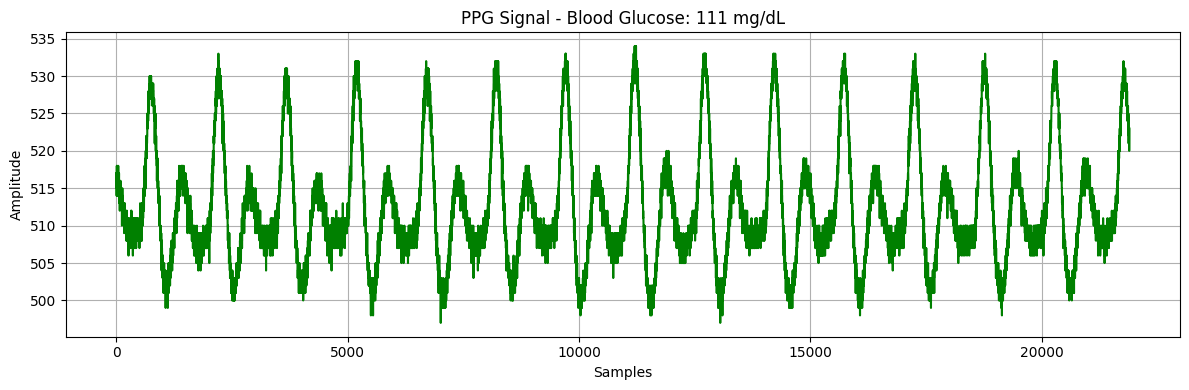

In [4]:
# List all raw signal files and label files
raw_files = sorted([f for f in os.listdir(rawdata_folder) if f.endswith(".csv")])
label_files = sorted([f for f in os.listdir(labels_folder) if f.endswith(".csv")])

# Pick a sample 
sample_index = 9
raw_file = os.path.join(rawdata_folder, raw_files[sample_index])
label_file = os.path.join(labels_folder, label_files[sample_index])

# Load the signal (.csv file) for raw data
raw_data = pd.read_csv(raw_file)
signal = raw_data.iloc[:, 0].values  # Assuming the signal is in the first column

# Load the label (.csv file) for labels
label_data = pd.read_csv(label_file)

# Get glucose value (assuming it's in the 4th column)
glucose = label_data.iloc[0, 3]  # First row, 4th column (index starts at 0)

# Plot
plt.figure(figsize=(12, 4))
plt.plot(signal, color="green")
plt.title(f"PPG Signal - Blood Glucose: {glucose} mg/dL")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

### Data preprocessing 

In [5]:
TARGET_FS = 100
WINDOW_SIZE = 1

In [6]:
def preprocess_ppg(raw_signal, original_fs=2175):
    duration = len(raw_signal) / original_fs
    new_length = int(duration * TARGET_FS)
    x_orig = np.linspace(0, duration, len(raw_signal))
    x_new = np.linspace(0, duration, new_length)
    interpolator = interp1d(x_orig, raw_signal, kind='linear')
    resampled = interpolator(x_new)
    sos = sp.butter(3, [0.5, 8], btype='bandpass', fs=TARGET_FS, output='sos')
    filtered = sp.sosfiltfilt(sos, resampled)
    normalized = (filtered - np.mean(filtered)) / np.std(filtered)
    return normalized

In [7]:
def test_preprocess_ppg(raw_signal):
    sos = sp.butter(3, [0.5, 8], btype='bandpass', fs=TARGET_FS, output='sos')
    filtered = sp.sosfiltfilt(sos, raw_signal)
    normalized = (filtered - np.mean(filtered)) / np.std(filtered)
    return normalized

In [8]:
def create_segments(signal, window_size=WINDOW_SIZE, fs=TARGET_FS):
    samples_per_window = fs * window_size
    return [signal[i:i+samples_per_window] for i in range(0, len(signal) - samples_per_window, samples_per_window)]


In [9]:
class PPGDataset(Dataset):
    def __init__(self, raw_files, label_files):
        self.segments = []
        self.labels = []
        for raw_file, label_file in zip(raw_files, label_files):
            raw_signal = load_csv_file_new(os.path.join(rawdata_folder, raw_file))
            processed = preprocess_ppg(raw_signal)
            segments = create_segments(processed)

            glucose = load_csv_file(os.path.join(labels_folder, label_file))
            self.segments.extend(segments)
            self.labels.extend([glucose] * len(segments))

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        segment = torch.tensor(self.segments[idx], dtype=torch.float32).unsqueeze(0)  # (1, length)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return segment, label

# --- Prepare Dataset and DataLoader ---

raw_files = sorted([f for f in os.listdir(rawdata_folder) if f.endswith('.csv')])
label_files = sorted([f for f in os.listdir(labels_folder) if f.endswith('.csv')])  # <-- CSV now

full_dataset = PPGDataset(raw_files, label_files)

indices = list(range(len(full_dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Model 

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(channels)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return F.relu(out)

class GlucoseResNet(nn.Module):
    def __init__(self, input_channels=1):
        super(GlucoseResNet, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=3)

        self.layer1 = self._make_layer(64, 3)

        # Transition: 64 -> 128
        self.transition1 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=1),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        self.layer2 = self._make_layer(128, 3)

        # Transition: 128 -> 256
        self.transition2 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=1),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.layer3 = self._make_layer(256, 3)

        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(256, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 1)

    def _make_layer(self, channels, blocks):
        layers = [ResidualBlock(channels) for _ in range(blocks)]
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = self.layer1(x)
        x = self.pool2(x)

        x = self.transition1(x)
        x = self.layer2(x)
        x = self.pool2(x)

        x = self.transition2(x)
        x = self.layer3(x)
        x = self.pool2(x)

        x = self.global_avg_pool(x).squeeze(-1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x.squeeze(-1)



In [11]:
# --- Training and Evaluation ---
def train_model(model, train_loader, val_loader, epochs=100, lr=0.001, patience=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    best_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        val_loss = 0
        model.eval()
        with torch.no_grad():
            val_losses = []
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_losses.append(loss.item())
            val_loss = sum(val_losses) / len(val_losses)
        avg_train_loss = sum(train_losses) / len(train_losses)
        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {val_loss:.4f}')
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping triggered')
                break

In [12]:
def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).cpu().numpy()
            y_pred.extend(outputs)
            y_true.extend(targets.numpy())
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f'Test RMSE: {rmse:.2f} mg/dL')
    print(f'Test MAE: {mae:.2f} mg/dL')
    return y_true, y_pred


In [13]:
def clarke_error_grid(reference, predicted):
    fig, ax = plt.subplots(figsize=(8, 8))

    # Set plot limits
    ax.set_xlim(0, 400)
    ax.set_ylim(0, 400)

    # Background Colors for Zones
    # Zone E (extreme risk)
    ax.add_patch(patches.Rectangle((0, 0), 70, 70, facecolor='#8B0000', alpha=0.5))     # Hypoglycemia
    ax.add_patch(patches.Rectangle((180, 0), 220, 70, facecolor='#8B0000', alpha=0.5))   # Misinterpreted hypo
    ax.add_patch(patches.Rectangle((0, 180), 70, 220, facecolor='#8B0000', alpha=0.5))   # Misinterpreted hyper

    # Zone D (very high risk)
    ax.add_patch(patches.Polygon([[70,70],[180,70],[180,180],[70,180],[70,70]], facecolor='#B22222', alpha=0.5))

    # Zone C (high risk)
    ax.add_patch(patches.Rectangle((70,290), 210, 110, facecolor='#DC143C', alpha=0.5))
    ax.add_patch(patches.Rectangle((290,70), 110, 210, facecolor='#DC143C', alpha=0.5))

    # Zone B (low risk)
    ax.add_patch(patches.Polygon([[0,70],[70,70],[70,180],[0,180],[0,70]], facecolor='lightgreen', alpha=0.5))
    ax.add_patch(patches.Polygon([[70,0],[180,0],[180,70],[70,70],[70,0]], facecolor='lightgreen', alpha=0.5))
    ax.add_patch(patches.Polygon([[180,70],[400,70],[400,180],[180,180],[180,70]], facecolor='lightgreen', alpha=0.5))
    ax.add_patch(patches.Polygon([[70,180],[70,400],[180,400],[180,180],[70,180]], facecolor='lightgreen', alpha=0.5))

    # Zone A (no risk)
    ax.add_patch(patches.Polygon([[70,70],[180,70],[400,290],[400,400],[290,400],[70,180],[70,70]], facecolor='green', alpha=0.5))

    # Plotting the data points
    ax.scatter(reference, predicted, color='black', s=30, label="Predictions")

    # Plot Ideal 45 degree line
    ax.plot([0, 400], [0, 400], 'k--', label='Ideal')

    # Labels and title
    ax.set_xlabel('Reference Glucose (mg/dL)')
    ax.set_ylabel('Predicted Glucose (mg/dL)')
    ax.set_title('Clarke Error Grid Analysis')
    ax.legend()
    ax.grid(True)

    # Create custom legend manually
    import matplotlib.patches as mpatches
    green_patch = mpatches.Patch(color='green', label='No Risk (A)')
    lightgreen_patch = mpatches.Patch(color='lightgreen', label='Low Risk (B)')
    lightpink_patch = mpatches.Patch(color='lightpink', label='High Risk (C)')
    yellow_patch = mpatches.Patch(color='yellow', label='Very High Risk (D)')
    lightcoral_patch = mpatches.Patch(color='lightcoral', label='Extreme Risk (E)')

    plt.legend(handles=[green_patch, lightgreen_patch, lightpink_patch, yellow_patch, lightcoral_patch])
    plt.show()




### Training 

Epoch 1/100 - Train Loss: 10801.8322 - Val Loss: 13407.0758
Epoch 2/100 - Train Loss: 3707.3781 - Val Loss: 3031.9860
Epoch 3/100 - Train Loss: 609.0835 - Val Loss: 695.9369
Epoch 4/100 - Train Loss: 625.9718 - Val Loss: 1273.0746
Epoch 5/100 - Train Loss: 437.5145 - Val Loss: 970.9137
Epoch 6/100 - Train Loss: 456.3899 - Val Loss: 867.1486
Epoch 7/100 - Train Loss: 391.8662 - Val Loss: 826.0649
Epoch 8/100 - Train Loss: 367.2729 - Val Loss: 735.0431
Epoch 9/100 - Train Loss: 324.0373 - Val Loss: 767.4224
Epoch 10/100 - Train Loss: 312.1504 - Val Loss: 815.6918
Epoch 11/100 - Train Loss: 314.5668 - Val Loss: 851.4615
Epoch 12/100 - Train Loss: 361.1459 - Val Loss: 738.0268
Epoch 13/100 - Train Loss: 318.0988 - Val Loss: 639.8950
Epoch 14/100 - Train Loss: 306.5676 - Val Loss: 823.5066
Epoch 15/100 - Train Loss: 298.4112 - Val Loss: 536.5493
Epoch 16/100 - Train Loss: 278.1312 - Val Loss: 730.6354
Epoch 17/100 - Train Loss: 282.9346 - Val Loss: 615.4140
Epoch 18/100 - Train Loss: 248.22

C:\Users\nadha\AppData\Local\Temp\ipykernel_17084\2442280271.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test RMSE: 18.95 mg/dL
Test MAE: 15.27 mg/dL


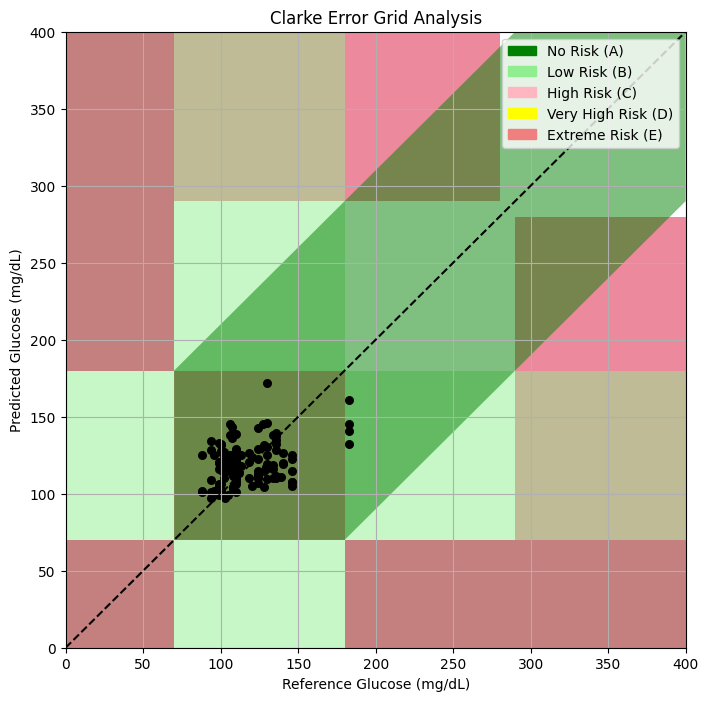

In [14]:
model = GlucoseResNet()
train_model(model, train_loader, test_loader, epochs=100, lr=0.001, patience=10)
model.load_state_dict(torch.load('best_model.pth'))
y_true, y_pred = evaluate_model(model, test_loader)
clarke_error_grid(y_true, y_pred)

In [15]:
import torch
import numpy as np

def evaluate_and_print(model, val_loader, device):
    model.eval()
    actual_values = []
    predicted_values = []
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            preds = model(X_batch).squeeze()
            actual_values.append(y_batch.cpu().numpy())
            predicted_values.append(preds.cpu().numpy())

    # Convert lists to numpy arrays
    actual_values = np.concatenate(actual_values)
    predicted_values = np.concatenate(predicted_values)

    # Print actual vs predicted values
    print("Actual vs Predicted values:\n")
    for act, pred in zip(actual_values, predicted_values):
        print(f"Actual: {act:.2f} | Predicted: {pred:.2f}")


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
evaluate_and_print(model , test_loader, device)

Actual vs Predicted values:

Actual: 99.00 | Predicted: 103.53
Actual: 106.00 | Predicted: 120.25
Actual: 94.00 | Predicted: 97.43
Actual: 108.00 | Predicted: 118.61
Actual: 103.00 | Predicted: 117.00
Actual: 99.00 | Predicted: 99.14
Actual: 146.00 | Predicted: 114.90
Actual: 96.00 | Predicted: 101.79
Actual: 108.00 | Predicted: 111.75
Actual: 111.00 | Predicted: 116.62
Actual: 108.00 | Predicted: 104.15
Actual: 88.00 | Predicted: 124.99
Actual: 146.00 | Predicted: 124.96
Actual: 129.00 | Predicted: 117.23
Actual: 110.00 | Predicted: 129.26
Actual: 134.00 | Predicted: 118.74
Actual: 130.00 | Predicted: 130.44
Actual: 110.00 | Predicted: 123.16
Actual: 110.00 | Predicted: 101.21
Actual: 106.00 | Predicted: 122.91
Actual: 118.00 | Predicted: 126.45
Actual: 136.00 | Predicted: 128.32
Actual: 99.00 | Predicted: 120.15
Actual: 124.00 | Predicted: 114.44
Actual: 88.00 | Predicted: 100.99
Actual: 140.00 | Predicted: 119.31
Actual: 102.00 | Predicted: 127.13
Actual: 124.00 | Predicted: 129.04


### Testing 

In [57]:
def load_csv_file_new(file_path):
    """Load .csv file and return the second column's values."""
    # Read the CSV file into a DataFrame
    data = pd.read_csv(file_path)
    
    # Extract and return only the second column (index 1)
    return data.iloc[:, 2].values  # returns the first column values





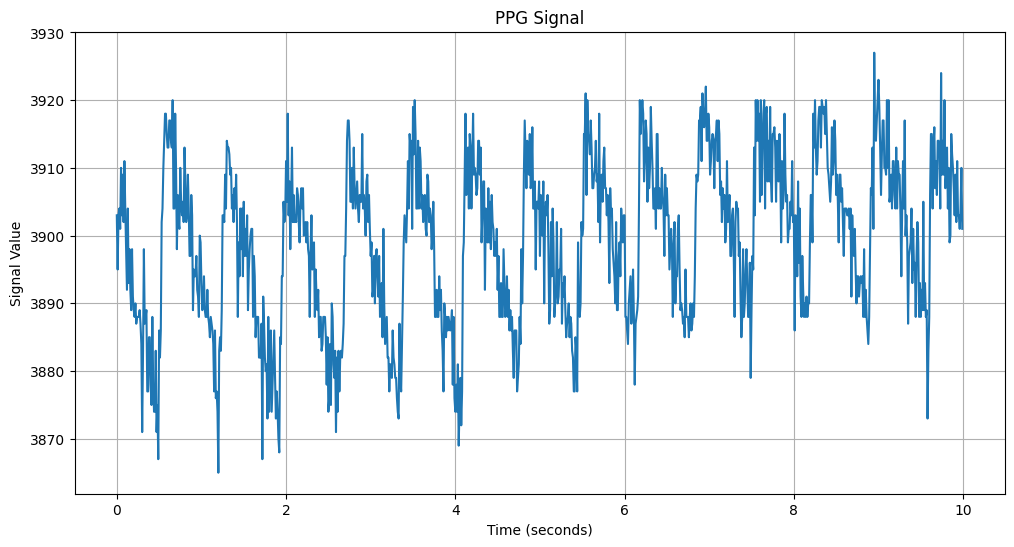

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
data = pd.read_csv('Data_9.csv', header=None)

# Extract the first column
signal = data.iloc[:, 2]  # First column

# Create a time axis (assuming 100Hz sampling rate)
sampling_rate = 100  # Hz
time = [i / sampling_rate for i in range(len(signal))]

# Plot the signal
plt.figure(figsize=(12, 6))
plt.plot(time, signal)
plt.title('PPG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.grid(True)
plt.show()


C:\Users\nadha\AppData\Local\Temp\ipykernel_17084\2572715357.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


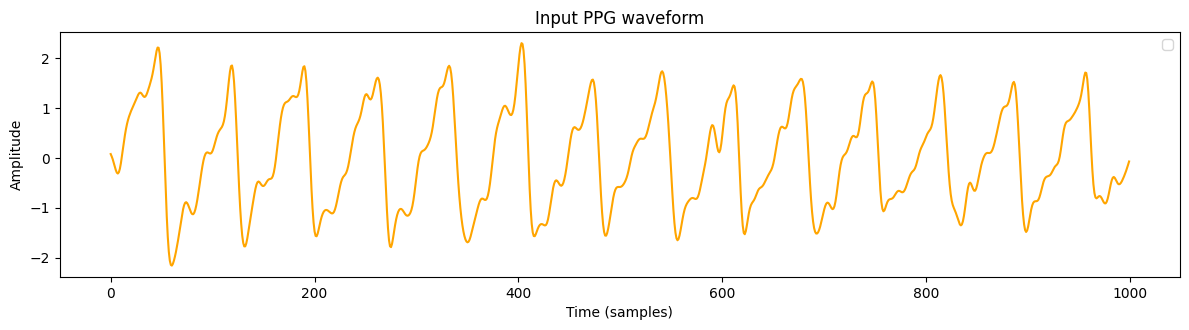

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
from scipy.interpolate import interp1d

signal = pd.read_csv('Data_9.csv', header=None)  # Modify with correct file path
signal_ = signal.iloc[:, 2].values  # 3rd column of signal_2
signal_processed = test_preprocess_ppg(signal_)  # Preprocess second signal

# Plot the signal
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 2)
plt.plot((-1)*signal_2_processed, color='orange')
plt.title("Input PPG waveform")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [60]:
def test_model_with_new_data(model, file_path):
    # Load the raw signal from the CSV file (assumes the file has 100Hz data)
    raw_signal = load_csv_file_new(file_path)
    
    # Preprocess the signal
    processed_signal = test_preprocess_ppg(raw_signal)
    
    # Create segments (using a window size of 1 second, for example)
    segments = create_segments(processed_signal)
    
    # Convert segments to a tensor
    segments_tensor = torch.tensor(segments, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    
    # Make predictions
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        predictions = model(segments_tensor)
    
    return predictions

In [61]:
def remove_outliers_and_average(predictions, method='zscore', threshold=2.0):
    """
    Remove outliers from predictions using z-score or IQR and return the average.
    """
    predictions = np.array(predictions).flatten()  # Flatten to 1D

    if method == 'zscore':
        mean = np.mean(predictions)
        std = np.std(predictions)
        filtered = predictions[np.abs((predictions - mean) / std) < threshold]
    
    elif method == 'iqr':
        q1 = np.percentile(predictions, 25)
        q3 = np.percentile(predictions, 75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        filtered = predictions[(predictions >= lower_bound) & (predictions <= upper_bound)]
    
    else:
        raise ValueError("Invalid method. Choose 'zscore' or 'iqr'.")

    return np.mean(filtered), filtered


In [62]:
predictions = test_model_with_new_data(model, 'Data_9.csv') #4th column

# Print predictions
print(predictions)
#Average predictions
average_prediction, _ = remove_outliers_and_average(predictions)
print("Average prediction:",average_prediction)

tensor([143.7856, 148.0476, 132.5775, 144.3269, 142.3300, 139.2387, 132.4432,
        127.1956, 122.6874])
Average prediction: 136.95915
